This notebook demonstrates the effect of using a pre-trained network. It is based on a couple of other tutorials that are available online.
* [http://parneetk.github.io/blog/cnn-cifar10/](http://parneetk.github.io/blog/cnn-cifar10/)
* [https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
* [https://github.com/stratospark/food-101-keras](https://github.com/stratospark/food-101-keras)
* [https://chsasank.github.io/keras-tutorial.html](https://chsasank.github.io/keras-tutorial.html)

In [1]:
import matplotlib.pyplot as plt

import os
import time
import numpy

from keras import backend as K
K.set_image_dim_ordering('th')
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.preprocessing.image import ImageDataGenerator

C:\Users\Michal\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next, we will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which depicts a labeled set of images beloning to 10 classes. For this tutorial, we will also reduce the size of the training set to (a) speed up training and to (b) mimic lack of labeled data.

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

# only consider a small subset of the training data
n_instances_train = 1000
n_instances_test = 2000
train_features = train_features[:n_instances_train, :, :, :]
train_labels = train_labels[:n_instances_train]
test_features = test_features[:n_instances_test, :, :, :]
test_labels = test_labels[:n_instances_test]
num_classes = len(numpy.unique(train_labels))

print("Number of training instances: %i" % train_features.shape[0])
print("Number of testing instances: %i" % test_features.shape[0])
print("Number of classes: %i" % num_classes)

# we need to resize the images such that they are suited for the pre-trained network (see below)
print("Resizing images ...")
from skimage import transform
train_features_new = []
for i in range(train_features.shape[0]):
    img = transform.resize(train_features[i], (3, 64, 64), mode="constant")
    train_features_new.append(img)
train_features = numpy.array(train_features_new)

test_features_new = []
for i in range(test_features.shape[0]):
    img = transform.resize(test_features[i], (3, 64, 64), mode="constant")
    test_features_new.append(img)
test_features = numpy.array(test_features_new)
print("Done!")

Number of training instances: 1000
Number of testing instances: 2000
Number of classes: 10
Resizing images ...
Done!


Next, let's plot some of the images!

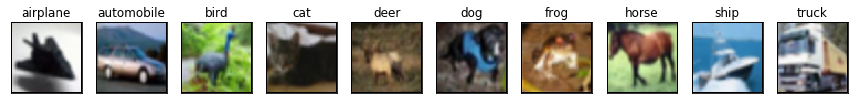

In [3]:
fig = plt.figure(figsize=(15,5))
all_class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

for i in range(num_classes):
    
    # get first image of class i 
    idx = numpy.where(train_labels[:]==i)[0]
    all_images_class_i = train_features[idx]
    im = numpy.transpose(all_images_class_i[0,::], (1, 2, 0))
    
    # plot image
    ax = fig.add_subplot(1, 10, 1 + i, xticks=[], yticks=[])
    ax.set_title(all_class_names[i])
    plt.imshow(im)
    
plt.show()

Again, we need to convert each label to a binary class vector. For instance, an instance with label 1 is mapped to a vector (0,1,0,0,0,0,0,0,0,0). Note that we do *not* rescale the images here anymore; it seems that the network was trained without rescaling as well.

In [4]:
# we do NOT rescale pixel values here
# train_features = train_features.astype('float32') / 255
# test_features = test_features.astype('float32') / 255

# convert each class label to a binary vector
train_labels_categorical = np_utils.to_categorical(train_labels, num_classes)
test_labels_categorical = np_utils.to_categorical(test_labels, num_classes)

One can load a pretrained network via keras. In this case, we gonna make use of the [VGG16 model](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) with weights that stem from training this big network on the [ImageNet](http://www.image-net.org/) dataset. Note that we do not include the final dense layers (include_top=False). This way, we can use the network to extract features!

In [5]:
from keras import applications

vgg_model = applications.VGG16(weights='imagenet', include_top=False)
print(vgg_model.summary())

train_features_extracted = vgg_model.predict(train_features)
test_features_extracted = vgg_model.predict(test_features)
print("Shape of extracted features: %s" % str(train_features_extracted.shape))

C:\Users\Michal\Anaconda3\lib\site-packages\keras\applications\vgg16.py:188: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

Given the features for both the training and testing data, we can now define and run standard machine learning models. We will consider two models: A standard neural network and random forests.

In [6]:
# standard neural network
model = Sequential()
model.add(Flatten(input_shape=train_features_extracted.shape[1:]))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the models using the extracted features!
print("Training model ...")
model_info = model.fit(train_features_extracted, 
                       train_labels_categorical, 
                       batch_size=128, 
                       nb_epoch=200, 
                       validation_data = (test_features_extracted, test_labels_categorical), 
                       verbose=1)
# let's save the weights for the next notebook
model.save_weights('vgg16_top_weights.h5')

Training model ...


C:\Users\Michal\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1000 samples, validate on 2000 samples
Epoch 1/200
1000/1000 [==============================] - 1s 790us/step - loss: 3.0010 - acc: 0.1110 - val_loss: 2.2805 - val_acc: 0.1355
Epoch 2/200
1000/1000 [==============================] - 0s 182us/step - loss: 2.3550 - acc: 0.1000 - val_loss: 2.2706 - val_acc: 0.2225
Epoch 3/200
1000/1000 [==============================] - 0s 192us/step - loss: 2.3275 - acc: 0.0990 - val_loss: 2.2690 - val_acc: 0.2015
Epoch 4/200
1000/1000 [==============================] - 0s 175us/step - loss: 2.3148 - acc: 0.1250 - val_loss: 2.2743 - val_acc: 0.2030
Epoch 5/200
1000/1000 [==============================] - 0s 191us/step - loss: 2.3294 - acc: 0.1080 - val_loss: 2.2761 - val_acc: 0.1840
Epoch 6/200
1000/1000 [==============================] - 0s 226us/step - loss: 2.3194 - acc: 0.1050 - val_loss: 2.2723 - val_acc: 0.2300
Epoch 7/200
1000/1000 [==============================] - 0s 203us/step - loss: 2.3159 - acc: 0.1180 - val_loss: 2.2682 - val_acc: 

1000/1000 [==============================] - 0s 219us/step - loss: 1.8145 - acc: 0.3250 - val_loss: 1.7279 - val_acc: 0.4420
Epoch 61/200
1000/1000 [==============================] - 0s 175us/step - loss: 1.8491 - acc: 0.3110 - val_loss: 1.7317 - val_acc: 0.4730
Epoch 62/200
1000/1000 [==============================] - 0s 179us/step - loss: 1.8121 - acc: 0.2980 - val_loss: 1.7802 - val_acc: 0.4855
Epoch 63/200
1000/1000 [==============================] - 0s 163us/step - loss: 1.8065 - acc: 0.3200 - val_loss: 1.7165 - val_acc: 0.4765
Epoch 64/200
1000/1000 [==============================] - 0s 185us/step - loss: 1.7895 - acc: 0.3170 - val_loss: 1.7377 - val_acc: 0.4680
Epoch 65/200
1000/1000 [==============================] - 0s 165us/step - loss: 1.8084 - acc: 0.3170 - val_loss: 1.7129 - val_acc: 0.4615
Epoch 66/200
1000/1000 [==============================] - 0s 185us/step - loss: 1.8054 - acc: 0.3340 - val_loss: 1.6826 - val_acc: 0.4845
Epoch 67/200
1000/1000 [=======================

1000/1000 [==============================] - 0s 186us/step - loss: 1.5227 - acc: 0.4320 - val_loss: 1.5523 - val_acc: 0.4955
Epoch 120/200
1000/1000 [==============================] - 0s 160us/step - loss: 1.5469 - acc: 0.4230 - val_loss: 1.5421 - val_acc: 0.4975
Epoch 121/200
1000/1000 [==============================] - 0s 201us/step - loss: 1.5219 - acc: 0.4150 - val_loss: 1.5750 - val_acc: 0.5005
Epoch 122/200
1000/1000 [==============================] - 0s 184us/step - loss: 1.4989 - acc: 0.4290 - val_loss: 1.5613 - val_acc: 0.4855
Epoch 123/200
1000/1000 [==============================] - 0s 182us/step - loss: 1.5384 - acc: 0.4190 - val_loss: 1.5417 - val_acc: 0.4965
Epoch 124/200
1000/1000 [==============================] - 0s 185us/step - loss: 1.5390 - acc: 0.4160 - val_loss: 1.5733 - val_acc: 0.4900
Epoch 125/200
1000/1000 [==============================] - 0s 189us/step - loss: 1.5489 - acc: 0.4070 - val_loss: 1.5519 - val_acc: 0.4985
Epoch 126/200
1000/1000 [================

1000/1000 [==============================] - 0s 160us/step - loss: 1.4506 - acc: 0.4320 - val_loss: 1.5959 - val_acc: 0.4975
Epoch 179/200
1000/1000 [==============================] - 0s 180us/step - loss: 1.3898 - acc: 0.4630 - val_loss: 1.6482 - val_acc: 0.4830
Epoch 180/200
1000/1000 [==============================] - 0s 183us/step - loss: 1.4031 - acc: 0.4430 - val_loss: 1.6559 - val_acc: 0.4960
Epoch 181/200
1000/1000 [==============================] - 0s 183us/step - loss: 1.3754 - acc: 0.4850 - val_loss: 1.6127 - val_acc: 0.4770
Epoch 182/200
1000/1000 [==============================] - 0s 187us/step - loss: 1.3429 - acc: 0.4820 - val_loss: 1.6171 - val_acc: 0.4875
Epoch 183/200
1000/1000 [==============================] - 0s 177us/step - loss: 1.3692 - acc: 0.4620 - val_loss: 1.6866 - val_acc: 0.4810
Epoch 184/200
1000/1000 [==============================] - 0s 189us/step - loss: 1.3664 - acc: 0.4750 - val_loss: 1.6433 - val_acc: 0.4970
Epoch 185/200
1000/1000 [================

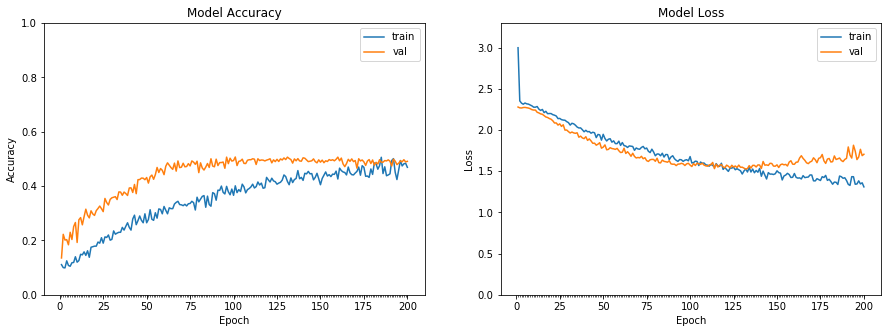

Accuracy on test data is: 49.10


In [7]:
def plot_model_history(model_history):

    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(numpy.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].set_ylim([0,1.0])

    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(numpy.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].set_ylim([0,1.1*max(numpy.array(model_history.history['loss']).max(), numpy.array(model_history.history['val_loss']).max())])
    
    plt.show()

def accuracy(test_x, test_y, model):
    
    result = model.predict(test_x)
    predicted_class = numpy.argmax(result, axis=1)
    true_class = numpy.argmax(test_y, axis=1)
    num_correct = numpy.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    
    return (accuracy * 100)

# plot model history
plot_model_history(model_info)

# compute test accuracy
print("Accuracy on test data is: %0.2f" % accuracy(test_features_extracted, test_labels_categorical, model))

Let's train a random forest for comparison ...

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# we need to reshape the data for sklearn
train_features_extracted = train_features_extracted.reshape((1000,4*512))
test_features_extracted = test_features_extracted.reshape((2000,4*512))

clf = RandomForestClassifier(n_estimators=500)
clf.fit(train_features_extracted, train_labels[:,0])
preds = clf.predict(test_features_extracted)

print("Accuracy on test data: %f" % accuracy_score(preds, test_labels[:,0]))

Accuracy on test data: 0.475000
